# ArXiv Abstract Classification

## 1. Data Collection

In [2]:
import requests
import xml.etree.ElementTree as ET
import pandas as pd
from google.colab import files

def fetch_abstracts(category, max_results=100):
    base_url = 'http://export.arxiv.org/api/query?'
    search_query = f'cat:{category}'
    query = f'{base_url}search_query={search_query}&max_results={max_results}'

    response = requests.get(query)

    if response.status_code == 200:
        root = ET.fromstring(response.content)
        entries = root.findall('{http://www.w3.org/2005/Atom}entry')

        results = []
        for entry in entries:
            title = entry.find('{http://www.w3.org/2005/Atom}title').text
            abstract = entry.find('{http://www.w3.org/2005/Atom}summary').text
            results.append({'category': category, 'title': title, 'abstract': abstract})

        return results
    else:
        print(f"Error fetching data: {response.status_code}")
        return []

# Collect data
categories = ['cs.AI', 'cs.LG', 'q-bio.NC']
all_data = []

for category in categories:
    print(f"Fetching data for category: {category}")
    category_data = fetch_abstracts(category)
    all_data.extend(category_data)
    print(f"Fetched {len(category_data)} abstracts for {category}")

df = pd.DataFrame(all_data)

# Display the first few rows of the dataframe
print(f"Total abstracts collected: {len(df)}")
df.head()

# Save the data to a CSV file and download
df.to_csv('arxiv_abstracts.csv', index=False)
files.download('arxiv_abstracts.csv')

Fetching data for category: cs.AI
Fetched 100 abstracts for cs.AI
Fetching data for category: cs.LG
Fetched 100 abstracts for cs.LG
Fetching data for category: q-bio.NC
Fetched 100 abstracts for q-bio.NC
Total abstracts collected: 300


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 2. Data Preprocessing

In [3]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Load the data
df = pd.read_csv('arxiv_abstracts.csv')
print(f"Total abstracts: {len(df)}")
print(df.head())

# Define a function to clean the text
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and digits
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    return text

# Apply the cleaning function to the 'abstract' column
df['cleaned_abstract'] = df['abstract'].apply(clean_text)

# Display a sample of original and cleaned abstract
print("Original Abstract:")
print(df['abstract'].iloc[0])
print("\nCleaned Abstract:")
print(df['cleaned_abstract'].iloc[0])

# Tokenize the cleaned abstracts
df['tokens'] = df['cleaned_abstract'].apply(word_tokenize)

# Remove stop words
stop_words = set(stopwords.words('english'))
df['tokens_without_stopwords'] = df['tokens'].apply(lambda x: [word for word in x if word not in stop_words])

# Display the results
print("\nTokens:")
print(df['tokens'].iloc[0][:20])  # Display first 20 tokens
print("\nTokens without stop words:")
print(df['tokens_without_stopwords'].iloc[0][:20])  # Display first 20 tokens

# Apply lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized_text'] = df['tokens_without_stopwords'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x]))

# Display a sample of the final preprocessed text
print("\nFinal preprocessed text:")
print(df['lemmatized_text'].iloc[0])

# Save the preprocessed data
df[['category', 'lemmatized_text']].to_csv('preprocessed_abstracts.csv', index=False)
print("\nPreprocessed data saved to 'preprocessed_abstracts.csv'")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Total abstracts: 300
  category                                              title  \
0    cs.AI                               Dynamic Backtracking   
1    cs.AI  A Market-Oriented Programming Environment and ...   
2    cs.AI            An Empirical Analysis of Search in GSAT   
3    cs.AI  The Difficulties of Learning Logic Programs wi...   
4    cs.AI  Software Agents: Completing Patterns and Const...   

                                            abstract  
0    Because of their occasional need to return t...  
1    Market price systems constitute a well-under...  
2    We describe an extensive study of search in ...  
3    As real logic programmers normally use cut (...  
4    To support the goal of allowing users to rec...  
Original Abstract:
  Because of their occasional need to return to shallow points in a search
tree, existing backtracking methods can sometimes erase meaningful progress
toward solving a search problem. In this paper, we present a method by which
backtrack p

## 3. Feature Extraction

In [4]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Load the preprocessed data
df = pd.read_csv('preprocessed_abstracts.csv')
print(f"Total abstracts: {len(df)}")
print(df.head())

# Initialize and fit the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to top 5000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(df['lemmatized_text'])

# Convert the TF-IDF matrix to a DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shape of the TF-IDF matrix and a sample
print(f"\nShape of TF-IDF matrix: {tfidf_matrix.shape}")
print("\nSample of TF-IDF features:")
print(tfidf_df.iloc[0].head())

# Split the data into training and testing sets
X = tfidf_matrix
y = df['category']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

# Save the feature names for later use
feature_names = tfidf_vectorizer.get_feature_names_out()
pd.Series(feature_names).to_csv('tfidf_features.csv', index=False)
print("\nTF-IDF feature names saved to 'tfidf_features.csv'")

Total abstracts: 300
  category                                    lemmatized_text
0    cs.AI  occasional need return shallow point search tr...
1    cs.AI  market price system constitute wellunderstood ...
2    cs.AI  describe extensive study search gsat approxima...
3    cs.AI  real logic programmer normally use cut effecti...
4    cs.AI  support goal allowing user record retrieve inf...

Shape of TF-IDF matrix: (300, 4752)

Sample of TF-IDF features:
ability        0.0
able           0.0
abnormality    0.0
abo            0.0
abrupt         0.0
Name: 0, dtype: float64

Training set shape: (240, 4752)
Testing set shape: (60, 4752)

TF-IDF feature names saved to 'tfidf_features.csv'


## 4. Model Development

### 4.1 Random Forest Classifier

Classification Report (Random Forest):
              precision    recall  f1-score   support

       cs.AI       0.94      0.73      0.82        22
       cs.LG       0.65      0.94      0.77        16
    q-bio.NC       1.00      0.91      0.95        22

    accuracy                           0.85        60
   macro avg       0.86      0.86      0.85        60
weighted avg       0.89      0.85      0.86        60



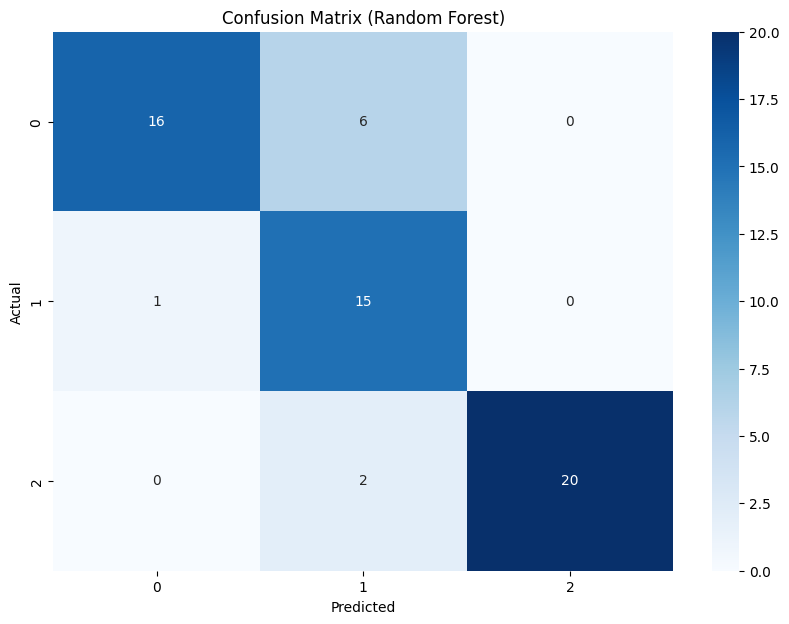

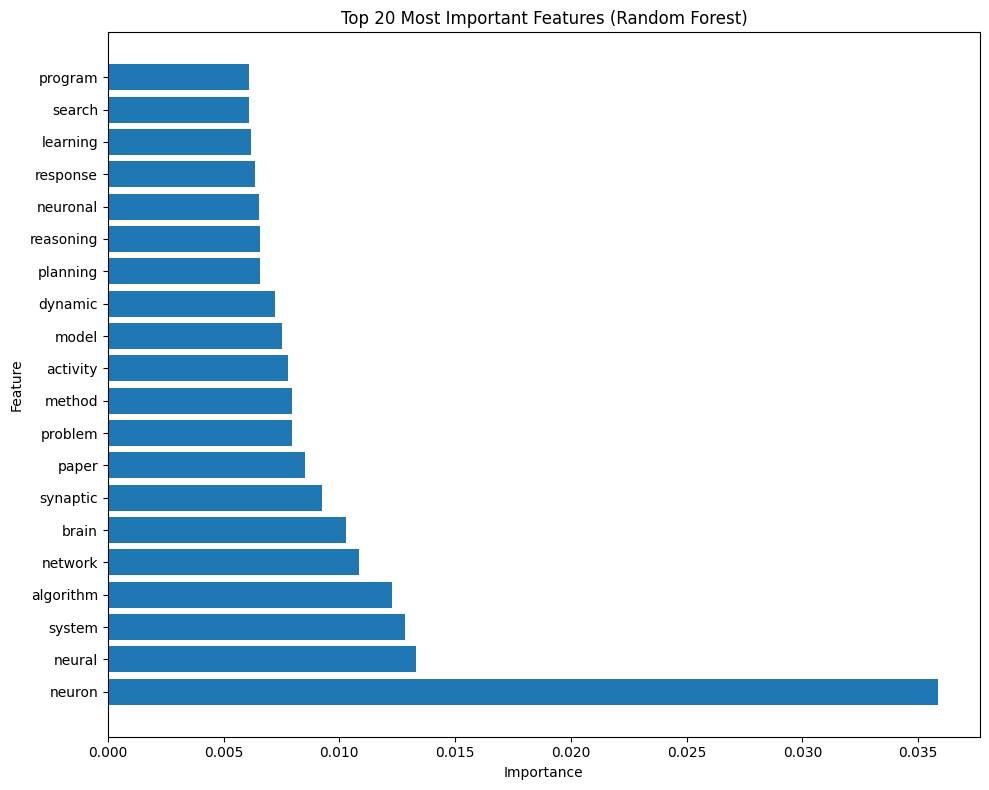

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and train the Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_classifier.predict(X_test)

# Print the classification report
print("Classification Report (Random Forest):")
print(classification_report(y_test, y_pred_rf))

# Create and plot confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10,7))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()

# Feature importance
feature_importance = rf_classifier.feature_importances_
feature_names = pd.read_csv('tfidf_features.csv')['0'].tolist()

# Get the top 20 most important features
top_20_idx = np.argsort(feature_importance)[-20:]
top_20_importance = feature_importance[top_20_idx]
top_20_features = [feature_names[i] for i in top_20_idx]

# Plot feature importance
plt.figure(figsize=(10,8))
plt.barh(range(20), top_20_importance, align='center')
plt.yticks(range(20), top_20_features)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Most Important Features (Random Forest)')
plt.gca().invert_yaxis()  # Invert y-axis to show most important at the top
plt.tight_layout()
plt.show()

### 4.2 Support Vector Machine (SVM) Classifier

Classification Report (SVM):
              precision    recall  f1-score   support

       cs.AI       0.95      0.95      0.95        22
       cs.LG       0.88      0.94      0.91        16
    q-bio.NC       1.00      0.95      0.98        22

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60



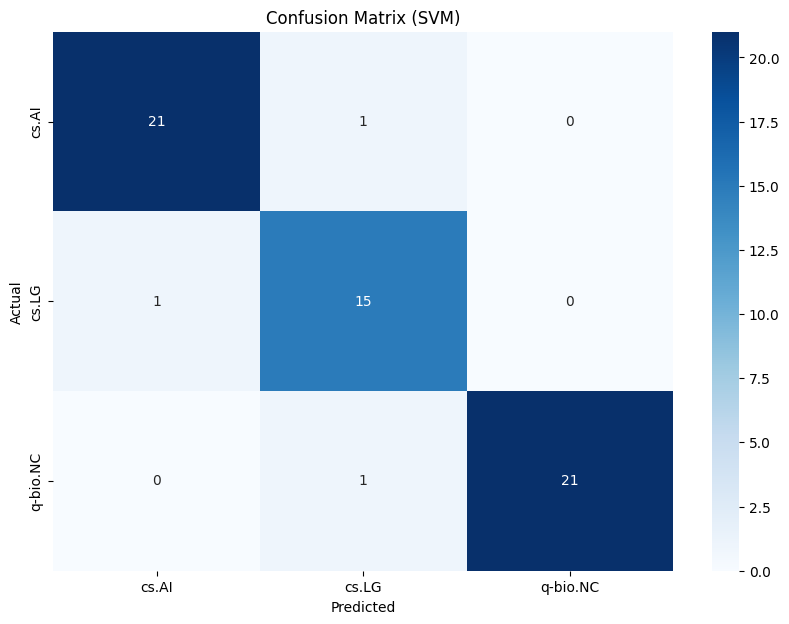


Overall Accuracy (SVM): 95.00%

Top 10 Most Important Features (SVM):
search: 1.4240
system: 1.2970
program: 1.2579
reasoning: 1.1419
planning: 1.1200
prediction: -1.0989
classifier: -1.0735
kernel: -1.0165
bound: -1.0110
clause: 0.9244


In [6]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Train SVM Classifier
svm_classifier = SVC(kernel='linear', random_state=42)
svm_classifier.fit(X_train, y_train)

# Make predictions
y_pred_svm = svm_classifier.predict(X_test)

# Print classification report
print("Classification Report (SVM):")
print(classification_report(y_test, y_pred_svm))

# Create confusion matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(10,7))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=svm_classifier.classes_,
            yticklabels=svm_classifier.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (SVM)')
plt.show()

# Print overall accuracy
accuracy = (cm_svm.diagonal().sum() / cm_svm.sum()) * 100
print(f"\nOverall Accuracy (SVM): {accuracy:.2f}%")

# Feature importance (for linear SVM)
feature_importance = svm_classifier.coef_.toarray()[0]
feature_names = tfidf_vectorizer.get_feature_names_out()
top_10_idx = abs(feature_importance).argsort()[-10:][::-1]
top_10_features = [(feature_names[i], feature_importance[i]) for i in top_10_idx]

print("\nTop 10 Most Important Features (SVM):")
for feature, importance in top_10_features:
    print(f"{feature}: {importance:.4f}")

## 5. Model Evaluation and Comparison

Model Comparison:

Random Forest Performance:
              precision    recall  f1-score   support

       cs.AI       0.94      0.73      0.82        22
       cs.LG       0.65      0.94      0.77        16
    q-bio.NC       1.00      0.91      0.95        22

    accuracy                           0.85        60
   macro avg       0.86      0.86      0.85        60
weighted avg       0.89      0.85      0.86        60


SVM Performance:
              precision    recall  f1-score   support

       cs.AI       0.95      0.95      0.95        22
       cs.LG       0.88      0.94      0.91        16
    q-bio.NC       1.00      0.95      0.98        22

    accuracy                           0.95        60
   macro avg       0.95      0.95      0.95        60
weighted avg       0.95      0.95      0.95        60


Random Forest Accuracy: 85.00%
SVM Accuracy: 95.00%


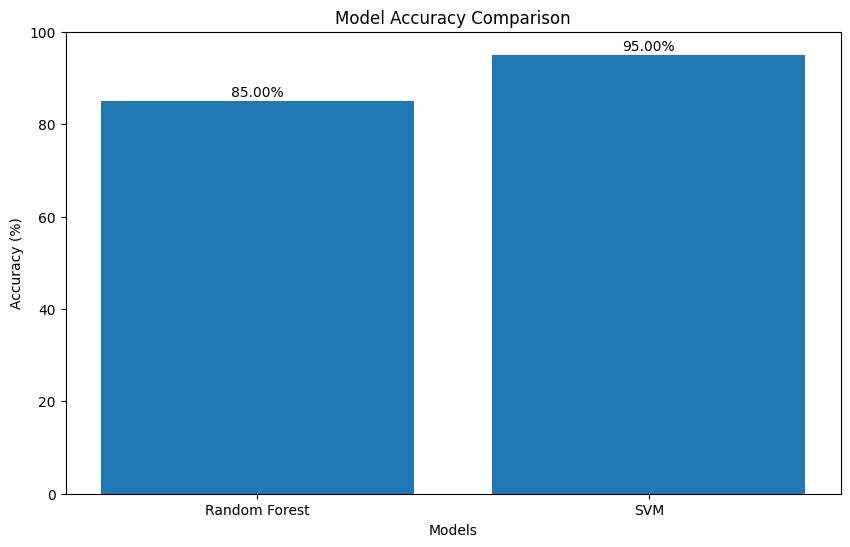

In [7]:
print("Model Comparison:")
print("\nRandom Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print("\nSVM Performance:")
print(classification_report(y_test, y_pred_svm))

# Compare accuracies
rf_accuracy = (cm_rf.diagonal().sum() / cm_rf.sum()) * 100
svm_accuracy = (cm_svm.diagonal().sum() / cm_svm.sum()) * 100

print(f"\nRandom Forest Accuracy: {rf_accuracy:.2f}%")
print(f"SVM Accuracy: {svm_accuracy:.2f}%")

# Visualize accuracy comparison
models = ['Random Forest', 'SVM']
accuracies = [rf_accuracy, svm_accuracy]

plt.figure(figsize=(10, 6))
plt.bar(models, accuracies)
plt.title('Model Accuracy Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
for i, v in enumerate(accuracies):
    plt.text(i, v + 1, f'{v:.2f}%', ha='center')
plt.show()

## 6. Save Best Model

In [8]:
import joblib

# Save the SVM model (assuming it's the best performing model)
joblib.dump(svm_classifier, 'svm_classifier.joblib')
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.joblib')

print("Model and vectorizer saved successfully.")

Model and vectorizer saved successfully.


## 7. Create Classification Function

In [9]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re

nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

def preprocess_text(text):
    # Convert to lowercase and remove special characters
    text = re.sub(r'[^a-zA-Z\s]', '', text.lower())

    # Tokenize
    tokens = word_tokenize(text)

    # Remove stopwords and lemmatize
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return ' '.join(lemmatized_tokens)

def classify_abstract(abstract):
    # Preprocess the abstract
    preprocessed_abstract = preprocess_text(abstract)

    # Transform the preprocessed abstract using the trained vectorizer
    abstract_vector = tfidf_vectorizer.transform([preprocessed_abstract])

    # Predict the category
    prediction = svm_classifier.predict(abstract_vector)

    return prediction[0]

# Test the classifier with sample abstracts
sample_abstracts = [
    "This paper presents a new algorithm for reinforcement learning in continuous state and action spaces.",
    "We propose a novel neural network architecture for image classification tasks.",
    "Our study investigates the role of dopamine in reward-based learning in the prefrontal cortex."
]

for i, abstract in enumerate(sample_abstracts, 1):
    category = classify_abstract(abstract)
    print(f"Abstract {i}:")
    print(f"Text: {abstract}")
    print(f"Predicted category: {category}\n")

Abstract 1:
Text: This paper presents a new algorithm for reinforcement learning in continuous state and action spaces.
Predicted category: cs.AI

Abstract 2:
Text: We propose a novel neural network architecture for image classification tasks.
Predicted category: q-bio.NC

Abstract 3:
Text: Our study investigates the role of dopamine in reward-based learning in the prefrontal cortex.
Predicted category: q-bio.NC



## 8. User Interface

In [10]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Create input widget
abstract_input = widgets.Textarea(
    value='',
    placeholder='Enter the abstract here...',
    description='Abstract:',
    disabled=False,
    layout=widgets.Layout(width='100%', height='150px')
)

# Create output widget
output = widgets.Output()

# Create button widget
button = widgets.Button(description="Classify")

# Define button click event
def on_button_clicked(b):
    with output:
        clear_output()
        abstract = abstract_input.value
        if abstract.strip() == '':
            print("Please enter an abstract.")
        else:
            category = classify_abstract(abstract)
            print(f"Predicted category: {category}")

# Link button click to event
button.on_click(on_button_clicked)

# Display widgets
display(abstract_input, button, output)

Textarea(value='', description='Abstract:', layout=Layout(height='150px', width='100%'), placeholder='Enter th…

Button(description='Classify', style=ButtonStyle())

Output()